In [2]:
import cv2
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skimage.feature import hog
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC

# Đường dẫn đến các thư mục hình ảnh
train_dir = 'C:\\study\\ComputerVision\\NhapMonCV_SmokingDetection\\smoking_dataset\\Training\\images'
val_dir = 'C:\\study\\ComputerVision\\NhapMonCV_SmokingDetection\\smoking_dataset\\Validation\\images'
test_dir = 'C:\\study\\ComputerVision\\NhapMonCV_SmokingDetection\\smoking_dataset\\Testing\\images'

# scaler = MinMaxScaler()
scaler = StandardScaler()
BIN_SIZE = 64

def normalized_color_histogram(image):
    row, column, channel = image.shape[:3]
    size = row * column
    
    feature = []
    for k in range(channel):
        histogram = cv2.calcHist([image], [k], None, [BIN_SIZE], [0, 256])
        histogram = histogram / size
        feature.extend(histogram.flatten())
    return feature

# Hàm trích xuất đặc trưng Edge từ ảnh
def extract_edge_features(image):
    # Kiểm tra xem ảnh có phải là None hay không
    if image is None:
        print("Can't read image")
        return None  # Hoặc xử lý theo cách khác

    # Áp dụng Canny Edge Detection
    edges = cv2.Canny(image, 100, 200)

    # Chuyển đổi đặc trưng thành vector
    features = edges.flatten()

    return features

# Hàm trích xuất HOG features
def extract_hog_features(image):
    hog_features, hog_image = hog(image, orientations=10, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return hog_features

def preprocess(image):
    image = cv2.resize(image, (32, 32))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    cohist_feature = normalized_color_histogram(image)
    # edge_feature = extract_edge_features(image)
    hog_feature = extract_hog_features(image)

    combined_features = np.hstack((cohist_feature, hog_feature))

    return combined_features
    # return cohist_feature
# Hàm load dữ liệu và dán nhãn dựa trên tên tệp
def load_data_from_folder(folder_path):
    data = []
    labels = []
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            features = preprocess(image)  
            data.append(features)
            if img_name.lower().startswith('notsmoking'):
                labels.append(0)  # Lớp 'notsmoking'
            elif img_name.lower().startswith('smoking'):
                labels.append(1)  # Lớp 'smoking'
        else:
            print(f"Không thể load ảnh: {img_name}")
    return np.array(data), np.array(labels)

In [3]:
# Load dữ liệu từ các thư mục khác nhau
X_train, y_train = load_data_from_folder(train_dir)
X_val, y_val = load_data_from_folder(val_dir)
X_test, y_test = load_data_from_folder(test_dir)

# Chuẩn hóa dữ liệu
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# **KNN**

Find best params

In [3]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Khởi tạo GridSearchCV với KNeighborsClassifier
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

# Huấn luyện mô hình
grid.fit(X_train, y_train)

# In ra kết quả
print("Best parameters found: ", grid.best_params_)
print("Best accuracy: ", grid.best_score_)

# Đánh giá với tập test
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best accuracy:  0.7040015540015541
Accuracy: 0.7232142857142857
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       112
           1       0.71      0.76      0.73       112

    accuracy                           0.72       224
   macro avg       0.72      0.72      0.72       224
weighted avg       0.72      0.72      0.72       224



Training

In [4]:
import joblib
# Huấn luyện mô hình KNN
knn = KNeighborsClassifier(n_neighbors=11, metric='manhattan', weights="uniform") # standard scaler
# knn = KNeighborsClassifier(n_neighbors=7, metric='manhattan', weights="uniform") # Min max scaler
knn.fit(X_train, y_train)
# joblib.dump(knn, 'knn_model_1.pkl')

KNeighborsClassifier(metric='manhattan', n_neighbors=11)

Testing

In [79]:
# Dự đoán và đánh giá trên tập validation
y_val_pred = knn.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7555555555555555
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76        90
           1       0.77      0.73      0.75        90

    accuracy                           0.76       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.76      0.76      0.76       180



In [80]:
# Dự đoán và đánh giá trên tập test
y_test_pred = knn.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Test Accuracy: 0.7232142857142857
Test Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.69      0.71       112
           1       0.71      0.76      0.73       112

    accuracy                           0.72       224
   macro avg       0.72      0.72      0.72       224
weighted avg       0.72      0.72      0.72       224



In [6]:
test_folder ="C:\\study\\ComputerVision\\NhapMonCV_SmokingDetection\\test_img"
for test in os.listdir(test_folder):
    test_path = os.path.join(test_folder, test)
    image = cv2.imread(test_path)
    if image is not None:
        features = preprocess(image)
        features = scaler.transform([features])
        prediction = knn.predict(features)
        if prediction == 0:
            print(f"{test} : Not smoking")
        else:
            print(f"{test} : Smoking")
    else:
        print(f"Can't load image: {test}")

notsmoking1.jpg : Not smoking
notsmoking2.webp : Not smoking
notsmoking_0393.jpg : Not smoking
notsmoking_0399.jpg : Not smoking
notsmoking_0403.jpg : Not smoking
notsmoking_0406.jpg : Not smoking
notsmoking_0409.jpg : Not smoking
notsmoking_0417.jpg : Smoking
notsmoking_0420.jpg : Not smoking
notsmoking_0449.jpg : Not smoking
notsmoking_0457.jpg : Not smoking
notsmoking_0462.jpg : Not smoking
notsmoking_0467.jpg : Not smoking
smoking1.jpg : Smoking
smoking2.jpg : Not smoking
smoking3.jpg : Smoking
smoking_0071.jpg : Not smoking
smoking_0176.jpg : Smoking
smoking_0185.jpg : Smoking
smoking_0190.jpg : Smoking
smoking_0224.jpg : Smoking
smoking_0240.jpg : Smoking
smoking_0246.jpg : Smoking


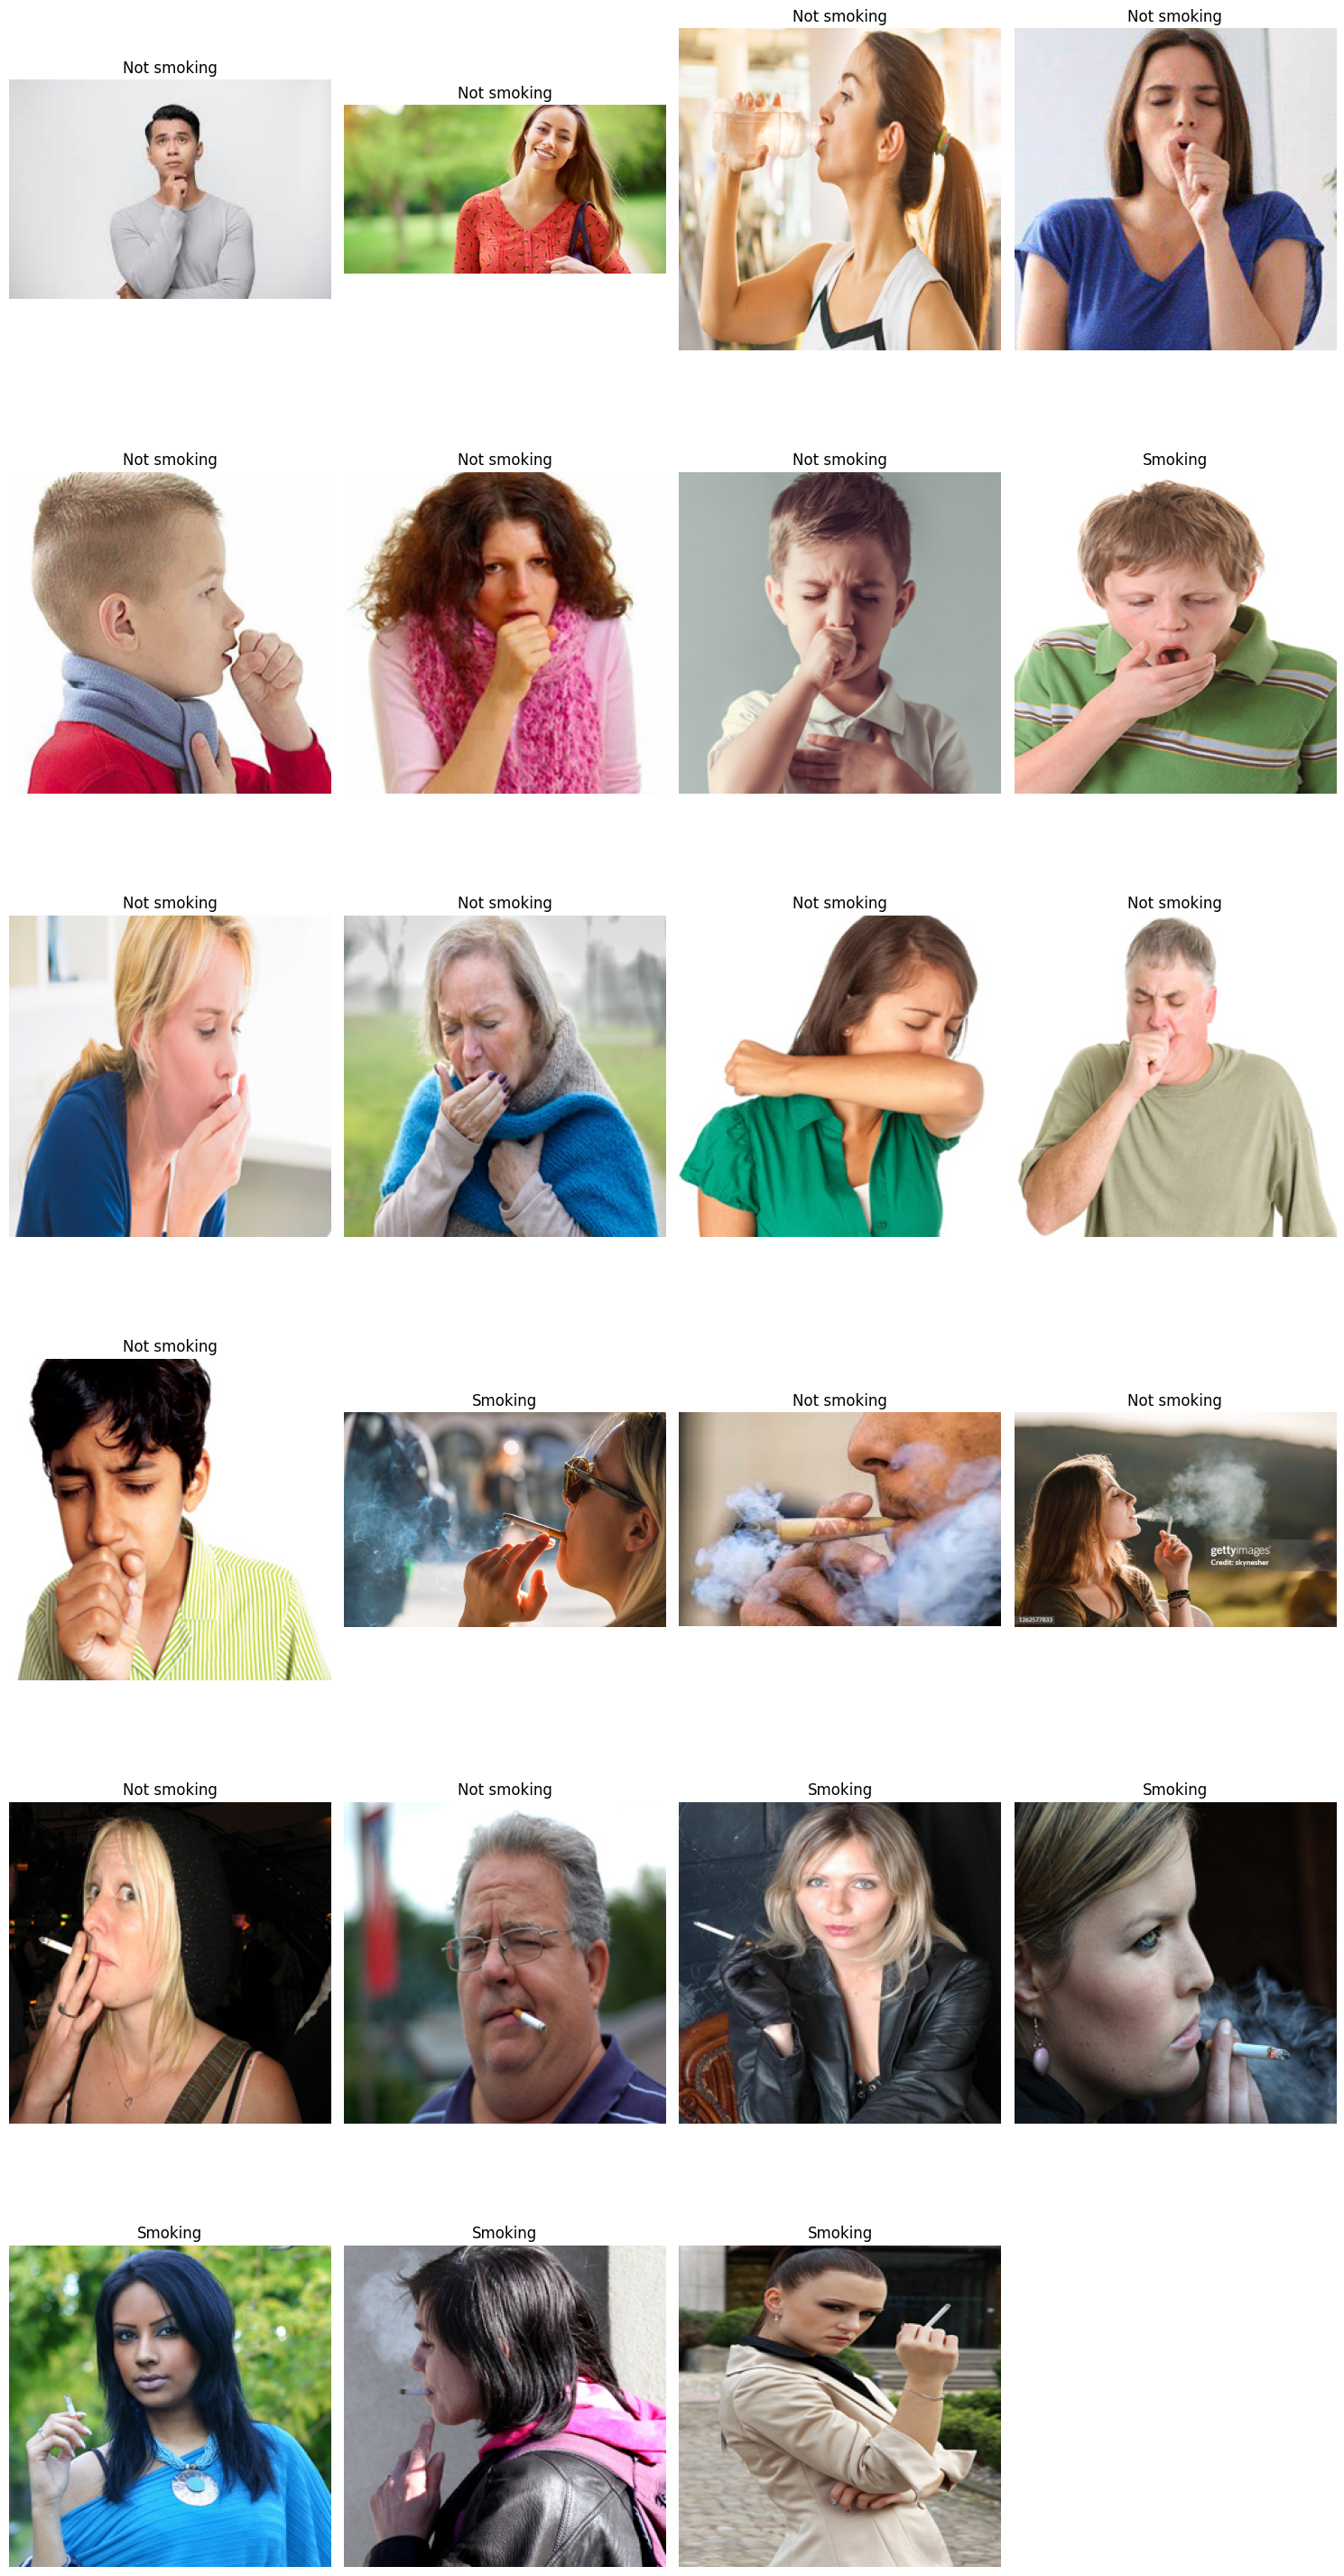

In [75]:
import matplotlib.pyplot as plt
import math

test_folder = "C:\\study\\ComputerVision\\NhapMonCV_SmokingDetection\\test_img"

images = []
labels = []

# Duyệt qua từng file trong thư mục
for test in os.listdir(test_folder):
    test_path = os.path.join(test_folder, test)
    image = cv2.imread(test_path)
    
    if image is not None:
        features = preprocess(image)  # Trích xuất đặc trưng từ ảnh
        features = scaler.transform([features])  # Chuẩn hóa đặc trưng

        # Dự đoán
        prediction = knn.predict(features)  # Thay thế với cách dự đoán của bạn
        
        # Đặt nhãn tương ứng
        if prediction[0] == 0:  # Giả định 0 là không hút thuốc
            label = "Not smoking"
        else:  # Giả định 1 là hút thuốc
            label = "Smoking"

        # Thêm ảnh và nhãn vào danh sách
        images.append(image)
        labels.append(label)
    else:
        print(f"Can't load image: {test}")

# Hiển thị tất cả các ảnh cùng với nhãn
num_images = len(images)
cols = 4  # Số cột
rows = math.ceil(num_images / cols)  # Tính số hàng

plt.figure(figsize=(15, 5 * rows))  # Điều chỉnh kích thước của figure theo số hàng
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)  # Điều chỉnh số hàng và cột theo số lượng ảnh
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Chuyển đổi màu sắc BGR -> RGB
    plt.title(labels[i])  # Đặt nhãn cho ảnh
    plt.axis('off')  # Tắt trục

plt.tight_layout()
plt.show()

In [82]:
x_testing, y_testing = load_data_from_folder(test_folder)
x_testing = scaler.transform(x_testing)
y_prediction = knn.predict(x_testing)
print("Test Accuracy:", accuracy_score(y_testing, y_prediction))
print("Test Classification Report:\n", classification_report(y_testing, y_prediction))

Test Accuracy: 0.8695652173913043
Test Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.89      0.80      0.84        10

    accuracy                           0.87        23
   macro avg       0.87      0.86      0.87        23
weighted avg       0.87      0.87      0.87        23

